<center><h2> Transfer learning for NLP</h2></center>

<br><br>
In this work I will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

In [2]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## __The Model__

__The next code implements a transformer-based model for text classification. It allows for the transfer learning of the transformer model on a specific classification task by adding a classification head on top of the pretrained transformer__

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        # The encoder
        self.encoder = nn.Embedding(ntoken, nhid)  # We initialise the embedding matrix representing our vocab as a (ntoken, nhid) dimension
        self.pos_encoder = PositionalEncoding(nhid, dropout)
        encoder_layers = nn.TransformerEncoderLayer(nhid, nhead, nhid, dropout=dropout) # we define the architecture of one encoder layer with a dropout in order to freeze some random weights from adjusting during the training process.
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)  # we stack the encoder layers
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask): # pass the input throw the "Base model"
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src)
        output= self.transformer_encoder(src, src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):  # Define the specific classification head
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses) # Pass the transformer results in order to predict the class as output
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module): # We stack all together
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout)
        self.classifier = ClassificationHead(nhid, nclasses)

    def forward(self, src, src_mask):

        x = self.base(src, src_mask) # pass throw the "Base model" for meaning assessing and textual relationships gathering
        output = self.classifier(x) # get output from the previous body and guess the class with the classification head
        return output

__The next class provides a way to add positional encodings to input sequences, which is essential for capturing the sequential order of tokens in transformer models. The positional encodings are added to the input embeddings before feeding them into the transformer model.__







In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

__Let's verify if our model works, by applying one inference step__

In [6]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([1, 6, 100])


__The shape is right because when we perform a Language modeling task, the classifier take vector of length "nhid" and try to guess the next work by predicting probabilities over all the vocabulary of size "ntokens". Then we just take the index of the max__

## __Vocabulary and Tokenization__

### ___Dowload the vocabulary___

In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

__In the next code we will prepare the vocabulary file, extracts information from it to create mappings between tokens and indices, and prints a token for verification purposes.__

In [8]:
path_vocab = "dict.txt"
ind2token = {}
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for index, line in enumerate(f):
        word = line.split()[0].strip()
        # token to index
        token2ind[word] = index + 4 # We index our vocab starting from the 4th index. This is used in order to encode the sentence for the feed forward

# index to token
ind2token = {v: k for k, v in token2ind.items()}  # This is used for decoding a sentence.

print(ind2token[4])

▁d


## __Data Loader__


__Now we define a PyTorch dataset class and data loader for our NLP tasks, specifically for language modeling and classification. The dataset reads text documents and, if applicable, corresponding labels from files. It tokenizes the input sequences, processes them based on the specified task, and provides the data in batches using PyTorch's DataLoader.__

In [9]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):

        # tokenize the input document
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]


        source_sequence = [self.token2ind["<sos>"]] #start our input with an sos
        for token in sequence: # for each token
            if token in self.token2ind: # if it is defined in our vocabulary
                source_sequence.append(self.token2ind[token])  # we append it to the tokenised sequence
            else:
                source_sequence.append(self.token2ind["<oov>"]) # else if we don't found the token we note as it is out of vocab


        # target construction

        if self.task == "language_modeling": # In this task we shift our output to the right in order to predict the next word based on the previous ones
            target = source_sequence[1:] # shift right without taking the <sos>
            target.append(self.token2ind["<eos>"]) # add the end of sentence

        elif self.task == "classification": # In this task the label would be the binary review classes
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }

        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## __Training for Language Modeling task__

__Defining the train function designed for training a neural network model, particularly suited for our use case natural language processing tasks like language modeling or classification__

In [10]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): # iterate over the data loader
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) # Feed forward
        if task == 'classification':
            #last vector only
            output = output[-1]
        output = output.view(-1, output.shape[-1])
        target = data[1]
        target = target.to(device)
        loss = criterion(output, target) # Compute the loss on both prediction and the ground truth
        loss.backward() # Feed backward the error for weight adjustment
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        optimizer.step()


        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [11]:
# vocab size
ntokens = len(token2ind)
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value
nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device) # initialise a language modeling model

In [12]:
# optimization paramerters
criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

In [14]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling",
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 10.77388 | ppl 47757.099
| epoch   1 |  1000/ 3125 steps | loss 9.96632 | ppl 21296.896
| epoch   1 |  1500/ 3125 steps | loss 9.38593 | ppl 11919.496
| epoch   1 |  2000/ 3125 steps | loss 9.04643 | ppl 8488.157
| epoch   1 |  2500/ 3125 steps | loss 8.79955 | ppl 6631.271
| epoch   1 |  3000/ 3125 steps | loss 8.65075 | ppl 5714.426
| epoch   2 |   500/ 3125 steps | loss 8.52672 | ppl 5047.856
| epoch   2 |  1000/ 3125 steps | loss 8.42826 | ppl 4574.522
| epoch   2 |  1500/ 3125 steps | loss 8.35164 | ppl 4237.114
| epoch   2 |  2000/ 3125 steps | loss 8.30418 | ppl 4040.735
| epoch   2 |  2500/ 3125 steps | loss 8.25864 | ppl 3860.836
| epoch   2 |  3000/ 3125 steps | loss 8.18930 | ppl 3602.191


## __Text Generation__


In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

__Using "SentencePiece", a library for subword tokenization, by loading a pre-trained French model, try to encode a sample sentence into subword pieces, and then decoding it back to the original form.__

In [ ]:
!pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

In [17]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind["<sos>"]] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = torch.argmax(out[-1, :, :], dim=1)

    return next_token_ind, out


def infer_next_tokens(sent, max_len=50):
    generated_tokens = sent # create the varibale to store the whole sentence progressively
    for _ in range(max_len):
        infered_ind, out = infer_next_token(generated_tokens) # make an inference
        next_token = ind2token[infered_ind.item()] #
        next_token = s.decode_pieces([next_token]) #stringify the next token
        if next_token == "<eos>":
            break  # Stop generation

        generated_tokens += " " + next_token # add the generated token to append the sentence

    return print(generated_tokens)


In [24]:
sent = "Cette maîtresse"
infer_next_tokens(sent)

Cette maîtresse a été tuée par le jeune homme .


### __Supervised task__

__Data for a classification task is being downloaded from the specified URLs__

In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

In [27]:
# evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader): # this puts the model on the evaluation mode by turning off some features like dropout
    model.eval() #
    total_acc = 0
    total_count = 0
    for idx, data in enumerate(data_loader): # iterate over batches
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )  # generate a mask
        input = data[0].to(device)
        output = model(input, src_mask) # make an inference
        output = output[-1] # take the last vector
        output = torch.argmax(output, dim=1) # grid search: taking the index with the max probability over the dim 1 (0 for the batches)
        target = data[1]
        target = target.to(device)
        acc = torch.sum(output == target).item() # take the correct predictions
        total_acc += acc
        total_count += len(target)
    return total_acc / total_count



In [28]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [ ]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

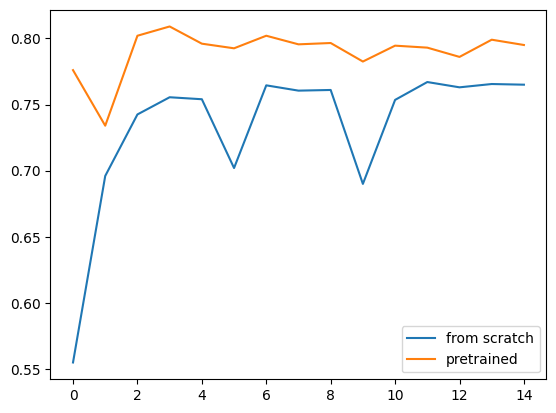

In [30]:
#Visualize the accuracy
import matplotlib.pyplot as plt
plt.plot(from_scratch_valid_acc, label='from scratch')
plt.plot(pretrained_valid_acc, label='pretrained')
plt.legend()


In the context of our model training, we compare both models, analyzing their respective performances and how they evolve across training epochs.

**Pretrained Model (Top accuracy: 80%):**
Initialized with weights learned from a vast amount of text data, the pretrained model begins with a higher accuracy compared to the second model. This initial advantage is expected since it carries knowledge from the pretrained weights. As the training progresses over multiple epochs, the accuracy of the model steadily improves, reaching a peak accuracy of 80%. This indicates that it has effectively leveraged the prior knowledge gained from pretraining, acquiring valuable features and representations from the large text corpus. This enhances its performance on the target task.

**From Scratch Model (Top accuracy: 78%):**
Conversely, the from scratch model starts with a lower accuracy compared to the pretrained model. This discrepancy arises from the fact that it begins with randomly initialized weights, devoid of any prior knowledge. As the training progresses, its accuracy improves, reaching a peak of 78%.

**Interpretation:**
The gap between the accuracy curves for both models clearly highlights the advantages of transfer learning using a pretrained model. The pretrained model consistently outperforms the from scratch model in terms of final accuracy. The higher initial accuracy reveals its capability to start with a head start in the fine-tuning task, as it has already acquired valuable features during pretraining, such as knowledge, semantics, and words polysemy. This demonstrates the importance of general natural language understanding.


In [31]:
# predict some data classification of the pretrained model
def predict(path_data_test, path_labels_test=None):
    model.eval()
    data_loader = get_loader(
        path_data_test,
        path_labels_test,
        token2ind=token2ind,
        batch_size=1,
        task='classification',
    )
    i= 0
    for idx, data in enumerate(data_loader):
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask)
        output = output[-1]
        prediction = torch.argmax(output, dim=1)
        ground_truth = data[1].item()

        # print original text and it's prediction classification
        if prediction == ground_truth:
            prediction_text = f'\033[92m{"Positive" if prediction == 1 else "Negative"}\033[0m'  # Green
            ground_truth_text = f'\033[92m{"Positive" if ground_truth == 1 else "Negative"}\033[0m'  # Green
        else:
            prediction_text = f'\033[91m{"Positive" if prediction == 1 else "Negative"}\033[0m'  # Red
            ground_truth_text = f'\033[91m{"Positive" if ground_truth == 1 else "Negative"}\033[0m'  # Red


        # Print the information
        print(s.decode_pieces([ind2token[ind.item()] for ind in input[1:]])) # original text decoded from tokens
        print(" --->")
        print(f'Predictions of the review: {prediction_text}')
        print(f'Ground Truth review: {ground_truth_text}')
        print('= = = = =\n')

        i +=1
        if i == 10:
            break


__Evaluates the classification predictions of a pretrained model on a given test dataset. It prints the original text along with the model's prediction and the ground truth classification. The output is color-coded (green for correct predictions, red for incorrect predictions.__

In [32]:
predict(path_data_valid, path_labels_valid)

ce livres et une vrai drogue! la derniere fois je n' arrivais meme pas a m' arreter!A LIRE ABSOLUMENT!!!!!!!!!!!!!!!
 --->
Predictions of the review: Negative
Ground Truth review: Positive
= = = = =

Livre agréable et étonnant par sa façon d'abordé l'argetn. J'ai déja un fcp que j'achète à ma banque et j'ai réalisé pas mal d'économies sur la réduction des frais d'entrée ainsi que bien d'autres économies en appliquant les conseils donné dans ce livre. J'ai 2 enfants qui ont des livrets d'épargnes et que j'ai changé pour faire plus que essayer d'absorber l'inflation, maintenant ils créent des richesses.
 --->
Predictions of the review: Negative
Ground Truth review: Positive
= = = = =

Je ne crois pas avoir déjà lu un livre aussi beau. Je ne savais pas du tout à quoi m'attendre lorsque j'ai ouvert le premier volume, mais au bout de quelques pages, j'étais déjà plongée dans l'histoire. J'ai dévoré les trois tomes à la suite ! C'est le genre d'ouvrage qui vous habite, vous hante, et restera

##__<center>END</center>__